In [2]:
!pip install pykrx

     |████████████████████████████████| 93 kB 1.1 MB/s 
     |████████████████████████████████| 51 kB 405 kB/s 
     |████████████████████████████████| 251 kB 13.8 MB/s 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      248 non-null    datetime64[ns]
 1   시가      248 non-null    int32         
 2   고가      248 non-null    int32         
 3   저가      248 non-null    int32         
 4   종가      248 non-null    int32         
 5   거래량     248 non-null    int32         
 6   거래대금    248 non-null    int64         
 7   등락률     248 non-null    float32       
dtypes: datetime64[ns](1), float32(1), int32(5), int64(1)
memory usage: 9.8 KB


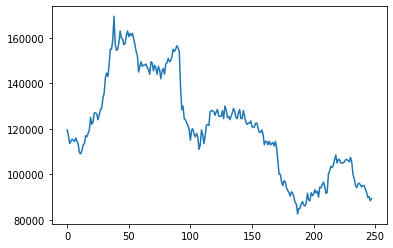

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#data = pd.read_csv('/Users/junho/Desktop/data/final_csv/score1.csv').drop('Unnamed: 0',axis=1)
#data.columns
#data.info()


from pykrx import stock
pykrx_df = stock.get_market_ohlcv_by_date(fromdate='2021-04-28', todate='2022-04-28', ticker="035720", adjusted=False)
pykrx = pykrx_df.reset_index()
pykrx.info()
pykrx # idx : 과거 -> 현재

pykrx['종가'].plot()

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_scaled = scaler.fit_transform(pykrx[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols
df_scaled

TEST_SIZE = 150
WINDOW_SIZE = 5
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]


def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)


feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 10)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))

test_feature = test[feature_cols]
test_label = test[label_cols]
# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 10)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(16,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='relu',
               return_sequences=False)
          )
model.add(Dense(1))


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(16,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='relu',
               return_sequences=False)
          )
model.add(Dense(1))

In [22]:
model.compile(loss='mean_squared_error', optimizer='adam')
#early_stop = EarlyStopping(monitor='val_loss', patience=5)
#filename = os.path.join(model_path, 'tmp_checkpoint.h5')
#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=50, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid))

Epoch 1/50
5/5 [==============================] - 3s 231ms/step - loss: 0.2813 - val_loss: 0.2187
Epoch 2/50
5/5 [==============================] - 0s 41ms/step - loss: 0.2012 - val_loss: 0.1504
Epoch 3/50
5/5 [==============================] - 0s 40ms/step - loss: 0.1283 - val_loss: 0.0890
Epoch 4/50
5/5 [==============================] - 0s 50ms/step - loss: 0.0679 - val_loss: 0.0425
Epoch 5/50
5/5 [==============================] - 0s 34ms/step - loss: 0.0248 - val_loss: 0.0154
Epoch 6/50
5/5 [==============================] - 0s 36ms/step - loss: 0.0096 - val_loss: 0.0072
Epoch 7/50
5/5 [==============================] - 0s 29ms/step - loss: 0.0118 - val_loss: 0.0082
Epoch 8/50
5/5 [==============================] - 0s 27ms/step - loss: 0.0147 - val_loss: 0.0075
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 0.0111 - val_loss: 0.0071
Epoch 10/50
5/5 [==============================] - 0s 27ms/step - loss: 0.0079 - val_loss: 0.0088
Epoch 11/50
5/5 [===========

In [23]:
pred = model.predict(test_feature)

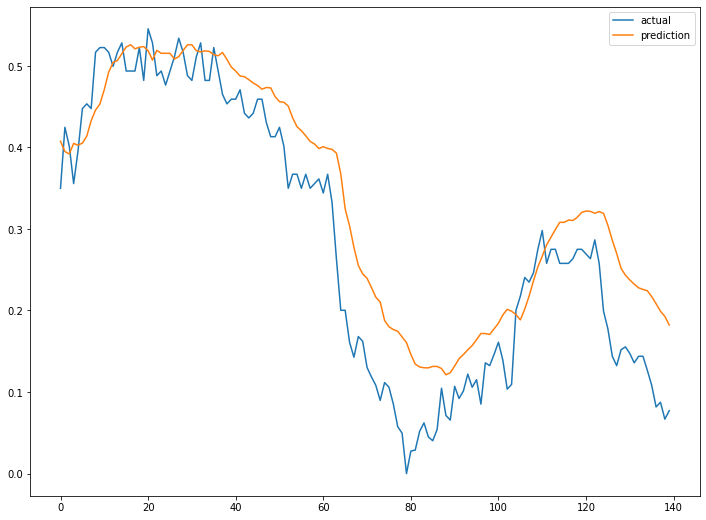

In [24]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()